In [2]:
import pandas as pd
import numpy as np
import math
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import signal

In [194]:
def generate_maq(n=100, q=1, c0=0, theta=0.6, sigma=1.0, seed=43):
    np.random.seed(seed)
    a_t = np.random.normal(loc=0, scale=sigma, size=n+q)#random noise
    r = np.zeros(n+q)
    r[:q] = a_t[:q]
    for t in range(q, n+q):
        r[t] = c0 + a_t[t] - np.dot(theta, a_t[t-q:t][::-1])
    return r[q:]

def generate_maq_with_seasonality_trend(n=100, q=1, c0=0, theta=0.6, sigma=1.0, seed=43,
                                        a=1/7, phase=0, trend_slope=0.1, ampl=1, integrate=True):
    """
    Generate an integrated MA(q) time series with added seasonality and trend.

    Parameters:
    - n (int): Number of data points to generate.
    - phi (float): Coefficient for the constant term.
    - theta (float): MA(1) coefficient.
    - sigma (float): Standard deviation of the noise.
    - seed (int): Random seed for reproducibility.
    - a (float): Frequency parameter for seasonality (1/7 for weekly seasonality).
    - trend_slope (float): Slope of the linear trend.

    Returns:
    - r (np.ndarray): Generated time series with MA(1), seasonality, and trend.
    """
    np.random.seed(seed)

    theta = np.array(theta)

    if q != theta.size:
        q = theta.size

    # Initialize the time series array
    r = generate_maq(n, q, c0, theta, sigma, seed)
    
    # Time index
    t_array = np.arange(n)

    # Add seasonality: cosine function with frequency a
    seasonality = ampl*np.cos(2 * np.pi * a * t_array + phase)

    # Add linear trend
    trend = trend_slope * t_array

    if integrate:
        # Integrate the time series
        r = np.cumsum(r)
    # Combine MA(1), seasonality, and trend
    r += seasonality + trend

    return r

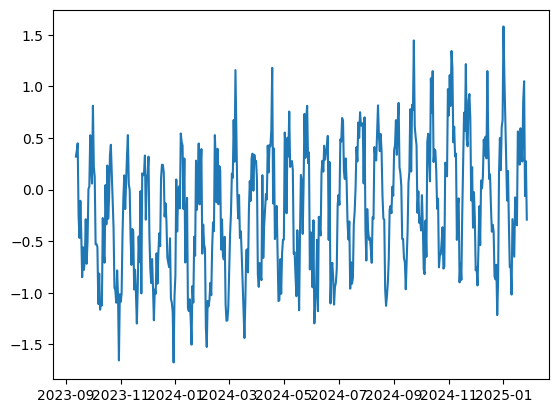

In [207]:
n = 504
dataset1_ma_with_seasonality_trend = generate_maq_with_seasonality_trend(n=n, q=1, c0=0, theta=[0.9], sigma=0.3, 
                                                                         seed=42, a=1/20, phase=np.pi/4, trend_slope=0, ampl=0.7, integrate=True)
from datetime import datetime, timedelta

# Generate a list of n consecutive dates ending with today
end_date = datetime.today()
date_list = [(end_date - timedelta(days=i)).strftime('%Y-%m-%d') for i in range(n)]

# Reverse the list to start from the earliest date
date_list.reverse()

dataset1 = pd.DataFrame({"Date":pd.to_datetime(date_list), "Value":dataset1_ma_with_seasonality_trend})
plt.plot(dataset1["Date"], dataset1["Value"])

[252.          21.          19.38461538 504.          20.16      ]
[  2.61117712   3.38335498   8.28257953  17.48823287 107.32268162]


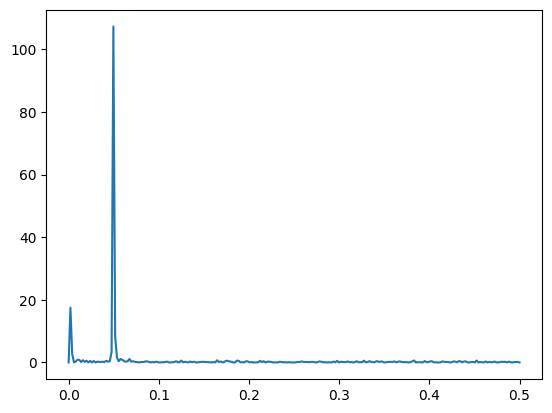

In [208]:
frequencies, power_spectrum = signal.periodogram(dataset1["Value"], fs=1)
plt.plot(frequencies, power_spectrum)
# get the index of the second max of power_spectrum to get the frequency
print(1/frequencies[np.argsort(power_spectrum)[-5:]])
print(np.sort(power_spectrum)[-5:])

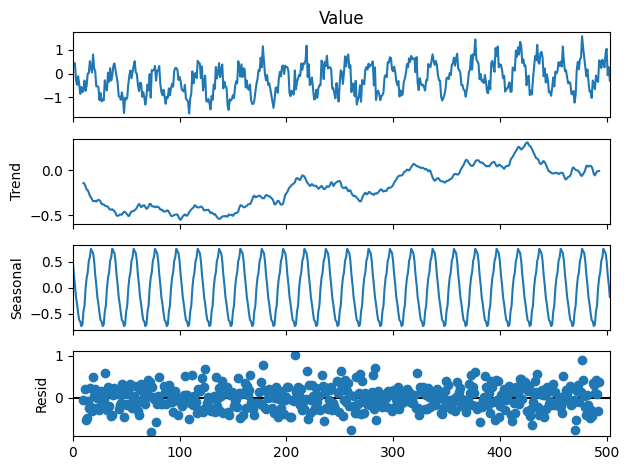

In [209]:
result_ma_season_trend = seasonal_decompose(dataset1["Value"], model='additive', period=20)
result_ma_season_trend.plot()
plt.show()

In [210]:
#dataset1 = pd.DataFrame(dataset1["Value"], columns=['value'])
dataset1.to_csv('dataset1.csv', index=False)

In [171]:
def generate_armapq_with_seasonality_trend(n=100, phi=[0.3, 0.4], theta=0.6, sigma=1.0, seed=43, a=1/7, trend_slope=0.1):
  np.random.seed(seed)

  # Generate white noise
  a_t = np.random.normal(loc=0, scale=sigma, size=n)

  # Initialize the time series array
  r = np.zeros(n)

  # Generate ARMA(1) process
  for t in range(1, n):
      r[t] = phi[0] + phi[1] * r[t-1] + phi[0] * (1 - theta) + a_t[t] - theta * a_t[t-1]

  # Time index
  t_array = np.arange(n)

  # Add seasonality: cosine function with frequency a
  seasonality = np.cos(2 * np.pi * a * t_array)

  # Add linear trend
  trend = trend_slope * t_array

  # Combine ARMA(1), seasonality, and trend
  r *= seasonality 
  r *= trend

  return r